# Train RNN to Solve Parametric Working Memory

In [23]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

bp.math.set_platform('cpu')

In [38]:
bp.__version__, bd.__version__

('2.4.3', '0.0.0.6')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [26]:
dataset = bd.cognitive.RateDelayComparison(t_decision=500.)
task = bd.cognitive.TaskLoader(dataset, batch_size=16)

In [27]:
class RNN(bp.DynamicalSystem):
  def __init__(self, num_input, num_hidden, num_output, num_batch,
               w_ir=bp.init.KaimingNormal(scale=1.),
               w_rr=bp.init.KaimingNormal(scale=1.),
               w_ro=bp.init.KaimingNormal(scale=1.),
               dt=None, seed=None):
    super(RNN, self).__init__()

    # parameters
    self.tau = 100
    self.num_batch = num_batch
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    if dt is None:
      self.alpha = 1
    else:
      self.alpha = dt / self.tau
    self.rng = bm.random.RandomState(seed=seed)

    # input weight
    self.w_ir = bm.TrainVar(bp.init.parameter(w_ir, (num_input, num_hidden)))

    # recurrent weight
    bound = 1 / num_hidden ** 0.5
    self.w_rr = bm.TrainVar(bp.init.parameter(w_rr, (num_hidden, num_hidden)))
    self.b_rr = bm.TrainVar(self.rng.uniform(-bound, bound, num_hidden))

    # readout weight
    self.w_ro = bm.TrainVar(bp.init.parameter(w_ro, (num_hidden, num_output)))
    self.b_ro = bm.TrainVar(self.rng.uniform(-bound, bound, num_output))

    self.reset_state(self.mode)

  def reset_state(self, batch_size):
    self.h = bp.init.variable_(bm.zeros, self.num_hidden, batch_size)
    self.o = bp.init.variable_(bm.zeros, self.num_output, batch_size)

  def cell(self, x, h):
    ins = x @ self.w_ir + h @ self.w_rr + self.b_rr
    state = h * (1 - self.alpha) + ins * self.alpha
    return bm.relu(state)

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def update(self, x):
    self.h.value = self.cell(x, self.h.value)
    self.o.value = self.readout(self.h.value)
    return self.h.value, self.o.value

  @bm.cls_jit
  def predict(self, xs):
    self.h[:] = 0.
    return bm.for_loop(self.update, xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    os = os.reshape((-1, os.shape[-1]))
    loss = bp.losses.cross_entropy_loss(os, ys.flatten())
    return loss, os

In [28]:
# Instantiate the network and print information
hidden_size = 64
with bm.environment(mode=bm.TrainingMode(batch_size=16)):
  net = RNN(num_input=dataset.num_inputs,
            num_hidden=hidden_size,
            num_output=dataset.num_outputs,
            num_batch=task.batch_size,
            dt=dataset.dt)

In [29]:
predict = bm.jit(net.predict)

In [30]:
# Adam optimizer
opt = bp.optim.Adam(lr=0.001, train_vars=net.train_vars().unique())

In [31]:
# gradient function
grad = bm.grad(net.loss,
               grad_vars=net.train_vars().unique(),
               return_value=True,
               has_aux=True)

In [32]:
@bm.jit
def train(xs, ys):
  grads, loss, os = grad(xs, ys)
  opt.update(grads)
  return loss, os

In [33]:
running_acc = []
running_loss = []
for i_batch in range(20):
    for X, Y in task:
        # training
        loss, outputs = train(bm.asarray(X), bm.asarray(Y))
        # Compute performance
        output_np = np.asarray(bm.argmax(outputs, axis=-1)).flatten()
        labels_np = np.asarray(Y).flatten()
        ind = labels_np > 0 # 0: fixation, 1: choice 1, 2: choice 2
        running_loss.append(loss)
        running_acc.append(np.mean(labels_np[ind] == output_np[ind]))
    print(f'Batch {i_batch + 1}, Loss {np.mean(running_loss):0.4f}, Acc {np.mean(running_acc):0.3f}')
    running_loss = []
    running_acc = []

Batch 1, Loss 0.4951, Acc 0.070
Batch 2, Loss 0.1510, Acc 0.696
Batch 3, Loss 0.0696, Acc 0.902
Batch 4, Loss 0.0520, Acc 0.922
Batch 5, Loss 0.0458, Acc 0.920
Batch 6, Loss 0.0433, Acc 0.936
Batch 7, Loss 0.0357, Acc 0.941
Batch 8, Loss 0.0337, Acc 0.943
Batch 9, Loss 0.0274, Acc 0.958
Batch 10, Loss 0.0262, Acc 0.959
Batch 11, Loss 0.0293, Acc 0.950
Batch 12, Loss 0.0248, Acc 0.966
Batch 13, Loss 0.0240, Acc 0.960
Batch 14, Loss 0.0185, Acc 0.971
Batch 15, Loss 0.0154, Acc 0.979
Batch 16, Loss 0.0258, Acc 0.957
Batch 17, Loss 0.0205, Acc 0.967
Batch 18, Loss 0.0224, Acc 0.954
Batch 19, Loss 0.0206, Acc 0.966
Batch 20, Loss 0.0213, Acc 0.966


In [34]:
def run(num_trial=1):
  net.reset_state(num_trial)
  inputs, trial_infos = bd.cognitive.TaskLoader(dataset, batch_size=num_trial).get_batch()
  rnn_activity, action_pred = predict(inputs)
  rnn_activity = bm.as_numpy(rnn_activity)

  # Concatenate activity for PCA
  pca = PCA(n_components=2)
  activity = rnn_activity.reshape(-1, net.num_hidden)
  pca.fit(activity)
  # print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
  for i in range(num_trial):
    activity_pc = pca.transform(rnn_activity[:, i])
    color = 'red' if trial_infos[-1, i] == 1 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
      _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
  ax1.set_xlabel('PC 1')
  ax1.set_ylabel('PC 2')
  plt.show()

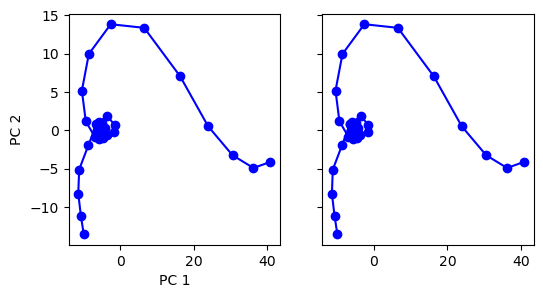

In [35]:
run(num_trial=1)

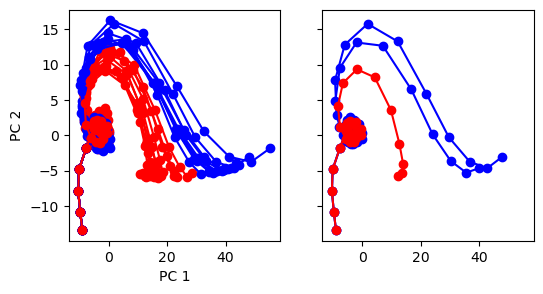

In [36]:
run(num_trial=20)

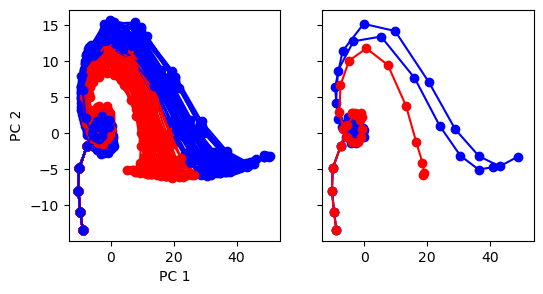

In [37]:
run(num_trial=100)